Requisitos de entrega:
- criação de série temporal para prever diariamente o fechamento da base

Será necessário demonstrar:
- o modelo com storytelling, desde a captura do dado até a entrega do modelo
- justificar a técnica utilizada
- atingir uma acuracidade adequada (acima de 70%)

---

# Características dos dados utilizados




*   Fonte de dados: https://br.investing.com/indices/bovespa-historical-data
*   Período de 01/06/2014 até 28/06/2024
*   Base de treino < 2024-04-01
*   Base de teste > 2024-04-01
*   Dados ausentes (fins de semana) foram preenchidos com fechamento do dia útil imediatamente anterior




---

A base utilizada não foi enviada pois a plataforma de envio não permite anexar mais de um arquivo.





# Escolha final do modelo de séries temporais

Para avaliar e justificar a escolha de um modelo de séries temporais com base nas métricas de validação obtidas, é importante considerar não apenas a precisão dos modelos, mas também o consumo de recursos computacionais e a complexidade de cada um deles.

---


**Análise dos Modelos com Base no wMAPE, MSE e RMSE**
--

**Naive**

- WMAPE: 2.30%
- MSE: 13.32
- RMSE: 3.65

**SeasonalNaive**

- WMAPE: 2.40%
- MSE: 14.68
- RMSE: 3.83

**SeasonalWindowAverage**

- WMAPE: 2.13%
- MSE: 10.74
- RMSE: 3.28

**AutoARIMA**

- WMAPE: 2.30%
- MSE: 13.32
- RMSE: 3.65

**AutoETS**

- WMAPE: 2.33%
- MSE: 13.81
- RMSE: 3.72

**Prophet**

- WMAPE: 2.42%
- MSE: 12.12
- RMSE: 3.48

--
**Justificativa da Escolha**
--
Modelo Escolhido: SeasonalWindowAverage

Justificativa:

1. Melhor Precisão: O SeasonalWindowAverage tem as melhores métricas de validação, indicando a maior precisão nas previsões.
2. Eficiência de Recursos: Este modelo é moderado em termos de consumo de recursos computacionais, o que é uma boa vantagem em relação aos modelos mais complexos como AutoARIMA e Prophet.
2. Complexidade Moderada: Oferece um bom equilíbrio entre precisão e simplicidade, sendo mais fácil de implementar e manter do que modelos mais complexos.

--

**Conclusão**
--
Considerando tanto a precisão quanto os recursos utlizados por cada método, SeasonalWindowAverage é a melhor escolha. Ele oferece a melhor precisão entre todas as opções e, apesar de exigir mais recursos computacionais do que os modelos mais simples (Naive e SeasonalNaive), é menos exigente do que AutoARIMA, AutoETS e Prophet.

**Pontos a considerar na escolha do SeasonalWindowAverage:**

- Precisão: Tem as melhores métricas (WMAPE, MSE, RMSE).
- Recursos computacionais: Boa relação entre precisão e eficiência computacional. Não é tão simples quanto Naive, mas também não é tão intensivo quanto AutoARIMA ou Prophet.
- Facilidade de implementação: É relativamente fácil de implementar e ajustar, o que o torna uma opção prática e a manutenção mais simples

--

**O passo a passo de código está abaixo**
---

# Importando bibliotecas básicas para análise de time series

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Análise, testes e validação de modelos de séries temporais

## 1 - conhecendo a base de dados

In [ ]:
# importando a base e visualizando sua estrutura
df = pd.read_csv('Dados Históricos - Ibovespa.csv', parse_dates=['Data'])
# df = pd.read_csv('Dados Históricos - Ibovespa.csv', parse_dates=[0], index_col='Data')
df.head(10)

<ipython-input-91-a2d6e1f12764>:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('Dados Históricos - Ibovespa.csv', parse_dates=['Data'])


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-06-28,123.907,124.308,124.500,123.298,"9,07B","-0,32%"
1,2024-06-27,124.308,122.642,124.308,122.642,"8,71B","1,36%"
2,2024-06-26,122.641,122.331,122.701,121.402,"8,18B","0,25%"
3,2024-06-25,122.331,122.634,122.849,121.997,"6,94M","-0,25%"
4,2024-06-24,122.637,121.343,122.840,121.307,"7,84M","1,07%"
5,2024-06-21,121.341,120.446,121.580,120.061,"12,91M","0,74%"
6,2024-06-20,120.446,120.267,121.607,120.156,"8,66M","0,15%"
7,2024-06-19,120.261,119.630,120.383,118.960,"5,65M","0,53%"
8,2024-06-18,119.630,119.138,120.109,118.872,"8,10M","0,41%"
9,2024-06-17,119.138,119.663,119.663,118.685,"7,38M","-0,44%"


In [ ]:
# compreendendo os tipos de dados e o shape da base
print(df.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2498 non-null   datetime64[ns]
 1   Último    2498 non-null   float64       
 2   Abertura  2498 non-null   float64       
 3   Máxima    2498 non-null   float64       
 4   Mínima    2498 non-null   float64       
 5   Vol.      2497 non-null   object        
 6   Var%      2498 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 136.7+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (2498, 7)


## 2 - completando os dias faltantes da coluna data (fins de semana)

In [ ]:
df = df.set_index('Data')
df = df.asfreq('D', method='pad')
df.reset_index(inplace=True)

# preenchendo o restante das colunas com o último valor válido
for column in df.columns:
    df[column].fillna(df[column].iloc[-1], inplace=True)

# verificando o resultado
df.head(10)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2014-06-02,51.606,51.239,51.879,51.239,"2,60M","0,72%"
1,2014-06-03,52.032,51.606,52.032,51.377,"2,86M","0,83%"
2,2014-06-04,51.833,52.032,52.032,51.609,"2,57M","-0,38%"
3,2014-06-05,51.559,51.833,52.245,51.470,"2,89M","-0,53%"
4,2014-06-06,53.129,51.562,53.175,51.562,"4,30M","3,05%"
5,2014-06-07,54.273,53.129,54.462,53.091,"3,66M","2,15%"
6,2014-06-08,54.273,53.129,54.462,53.091,"3,66M","2,15%"
7,2014-06-09,54.273,53.129,54.462,53.091,"3,66M","2,15%"
8,2014-06-10,54.604,54.273,54.604,53.960,"3,73M","0,61%"
9,2014-06-11,55.102,54.676,55.284,54.676,"3,80M","0,91%"


## 3 - preparação dos dados

In [ ]:
# incluindo coluna categórica
df['unique_id'] = 'ibovespa'

In [ ]:
# renomeando colunas
df = df.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
df = df[['ds', 'y', 'unique_id']]
df.head(1)

,ds,y,unique_id
0,2014-06-02,51.606,ibovespa


## 4 - identificando estacionariedade

### 1 - teste inicial

In [ ]:
# df com data como índice e valores só coluna y
df1 = df[['ds', 'y']]
df1 = df1.set_index('ds')

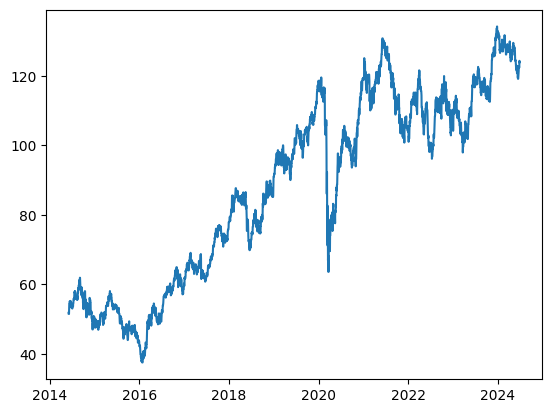

In [ ]:
plt.plot(df1.index, df1.values)

In [ ]:
resultados = seasonal_decompose(df1)

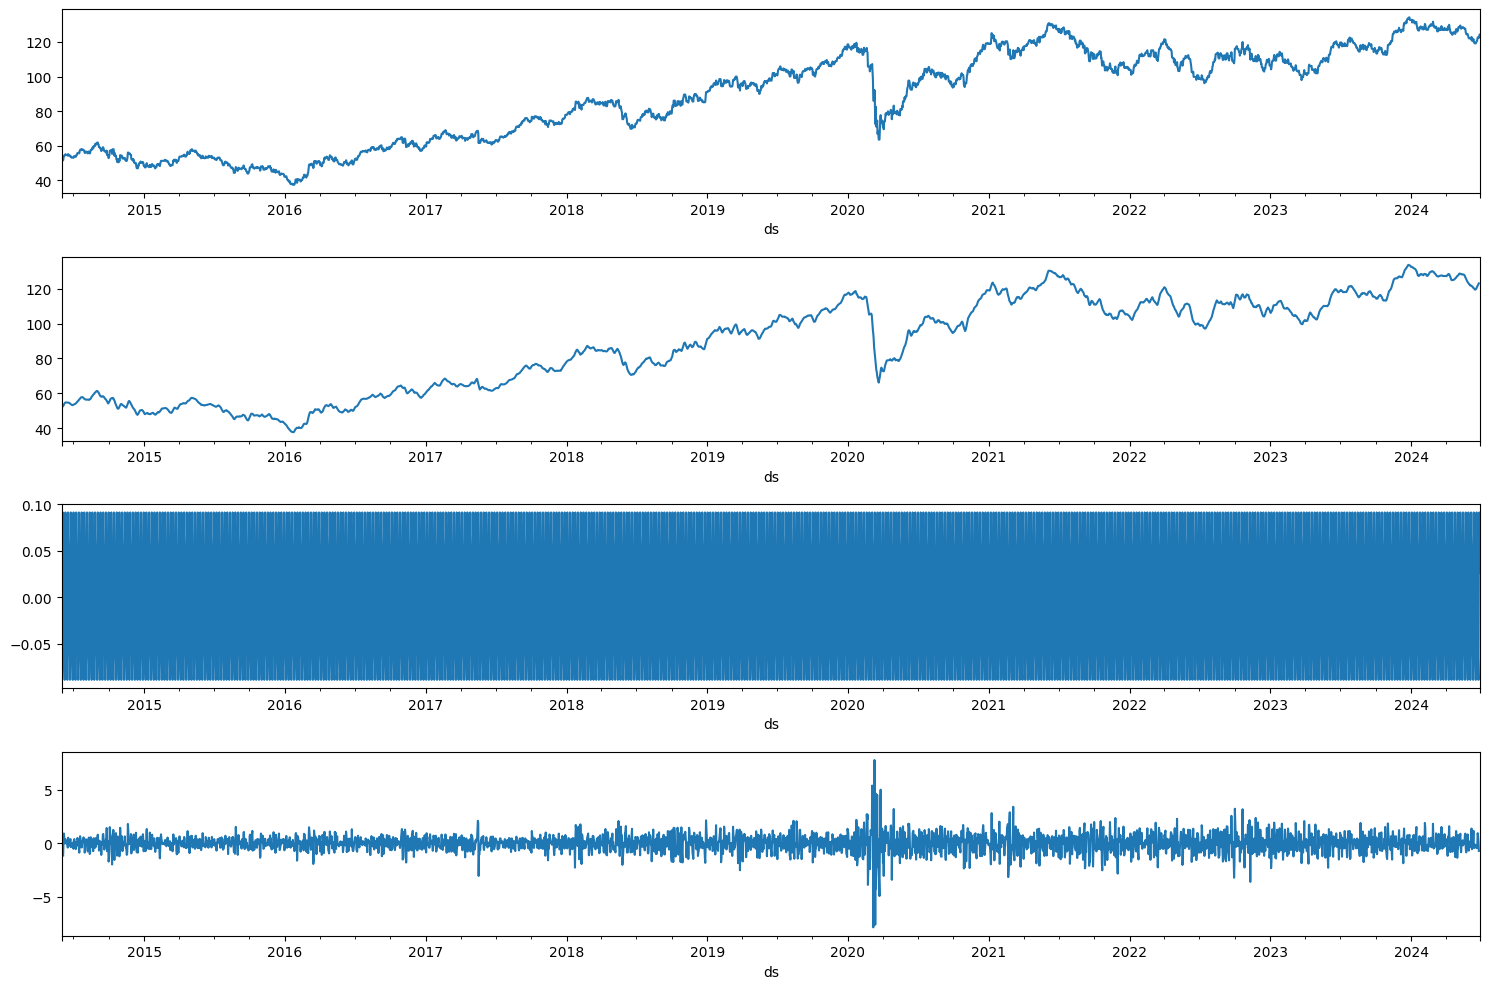

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
X = df1.y.values

In [ ]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.269900146854649
P-Value: 0.642828098992703
Valores críticos:
	1%: -3.432136971533937
	5%: -2.8623295847035983
	10%: -2.5671903077736693


### 2 - transformando série não estacionária em estacionária

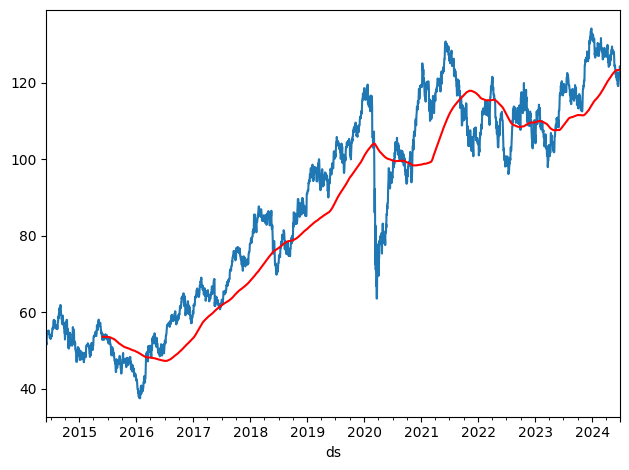

In [ ]:
ma = df1.rolling(365).mean()

f, ax = plt.subplots()
df1.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

### 3 - aplicando log

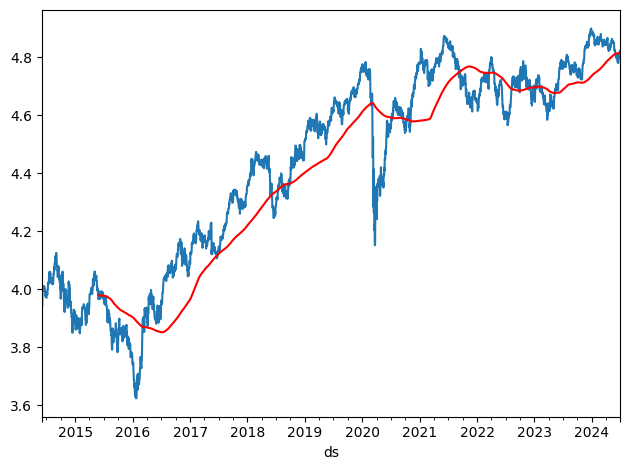

In [ ]:
df1_log = np.log(df1) #não é necessário especificar uma coluna pq o df só tem uma coluna
ma_log = df1_log.rolling(365).mean()

f, ax = plt.subplots()
df1_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

### 4 - subtraindo a média móvel dos dados (log aplicado)

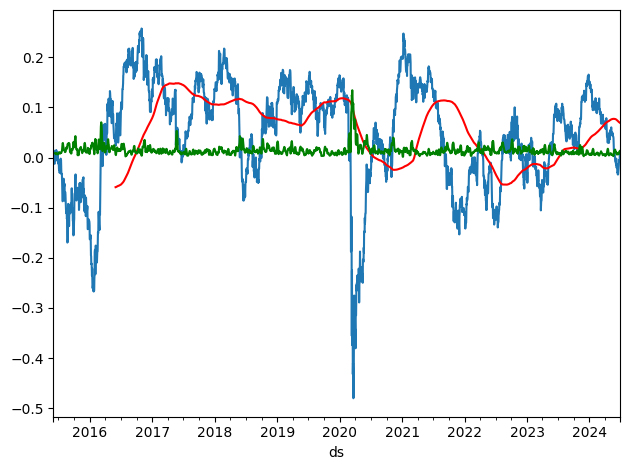

In [ ]:
df1_s = (df1_log - ma_log).dropna()

ma_s = df1_s.rolling(365).mean()

std = df1_s.rolling(12).std()

f, ax = plt.subplots()
df1_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

### 5 - novo teste adf

In [ ]:
X_s = df1_s.y.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -3.8813457061387546
P-Value: 0.0021765032114626263
Valores críticos:
	1%: -3.432334353260866
	5%: -2.8624167700089744
	10%: -2.5672367227799637


### 6 - aplicando diferenciação/derivada para diminuir ainda mais o p-value

Teste ADF
Teste Estatístico: -12.540234393085164
P-Value: 2.323244856293319e-23
Valores críticos:
	1%: -3.432334353260866
	5%: -2.8624167700089744
	10%: -2.5672367227799637


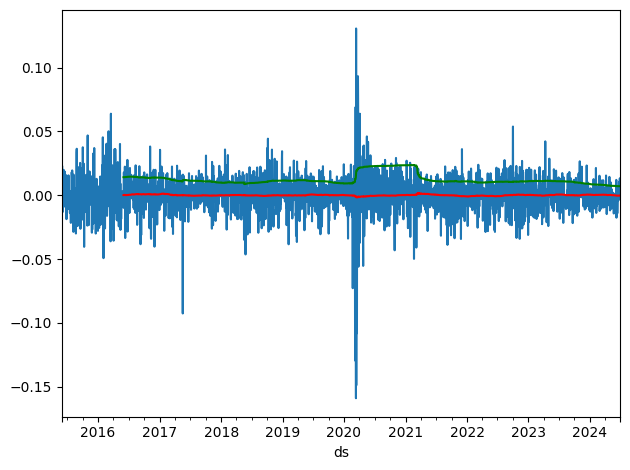

In [ ]:
df_diff = df1_s.diff(1) # 1 - primeira derivada/diferenciação
ma_diff = df_diff.rolling(365).mean()

std_diff = df_diff.rolling(365).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.y.dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

## 5 - separando bases de treino e validação

In [ ]:
# treino
treino = df.loc[df['ds'] < '2024-04-01']
# validação
valid = df.loc[(df['ds'] >= '2024-04-01') & (df['ds'] < '2024-07-01')]
# horizonte
h = valid['ds'].nunique()

In [ ]:
# selecionando um horizonte de aproximadamente 3 meses para manter a qualidade das previsões
h

89

## 6 - instalando o statsforecast

In [ ]:
pip install statsforecast

## 7 - criando função de validação (wMAPE)

In [ ]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

## 8 - criando modelos e realizando testes

### Naive - Baseline

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.30%
MSE: 13.321576746552303
RMSE: 3.6498735247337413


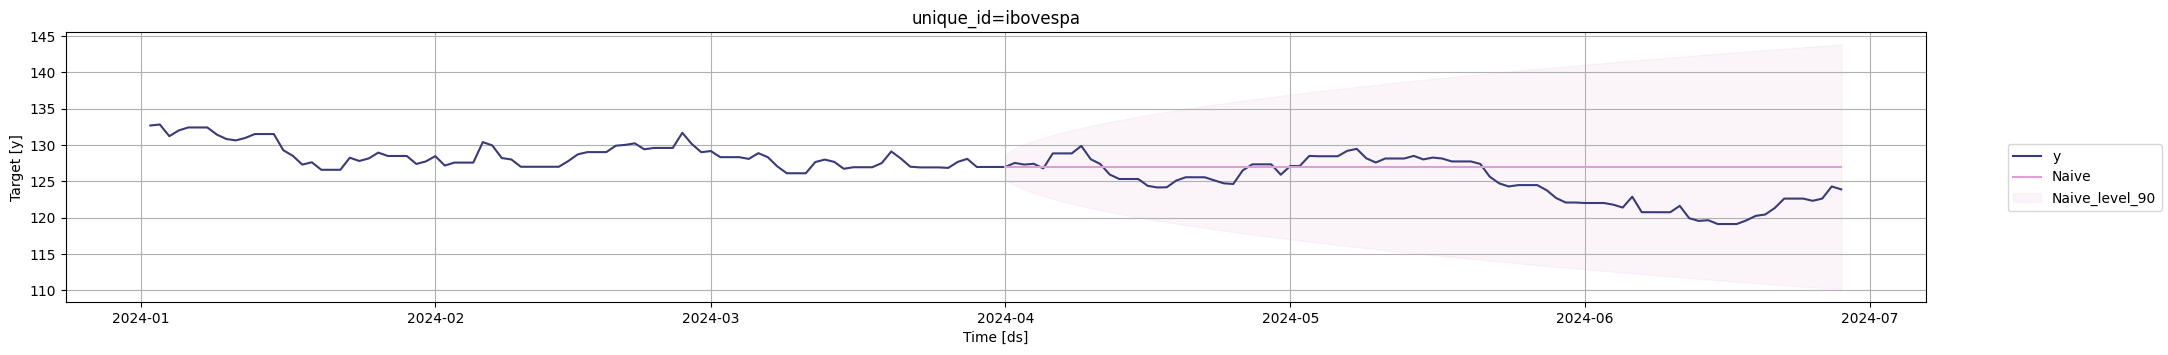

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

model_n = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model_n.fit(treino)

forecast_df_n = model_n.predict(h=h, level=[90])
forecast_df_n = forecast_df_n.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# wMAPE
wmape_n = wmape(forecast_df_n['y'].values, forecast_df_n['Naive'].values)
print(f'WMAPE: {wmape_n:.2%}')
# MSE
mse_n = mean_squared_error(forecast_df_n['y'], forecast_df_n['Naive'])
print('MSE:', mse_n)
# RMSE
rmse_n = np.sqrt(mse_n)
print('RMSE:', rmse_n)

model_n.plot(treino, forecast_df_n, level=[90], unique_ids=['ibovespa'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_df_n.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,ibovespa,2024-04-01,126.989998,125.202972,128.777023,126.990
1,ibovespa,2024-04-02,126.989998,124.462761,129.517242,127.549
2,ibovespa,2024-04-03,126.989998,123.894775,130.085220,127.318
3,ibovespa,2024-04-04,126.989998,123.415939,130.564056,127.428
4,ibovespa,2024-04-05,126.989998,122.994080,130.985916,126.795


### SeasonalNaive - Baseline com Sazonalidade

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.40%
MSE: 14.68347514875121
RMSE: 3.831902288518225


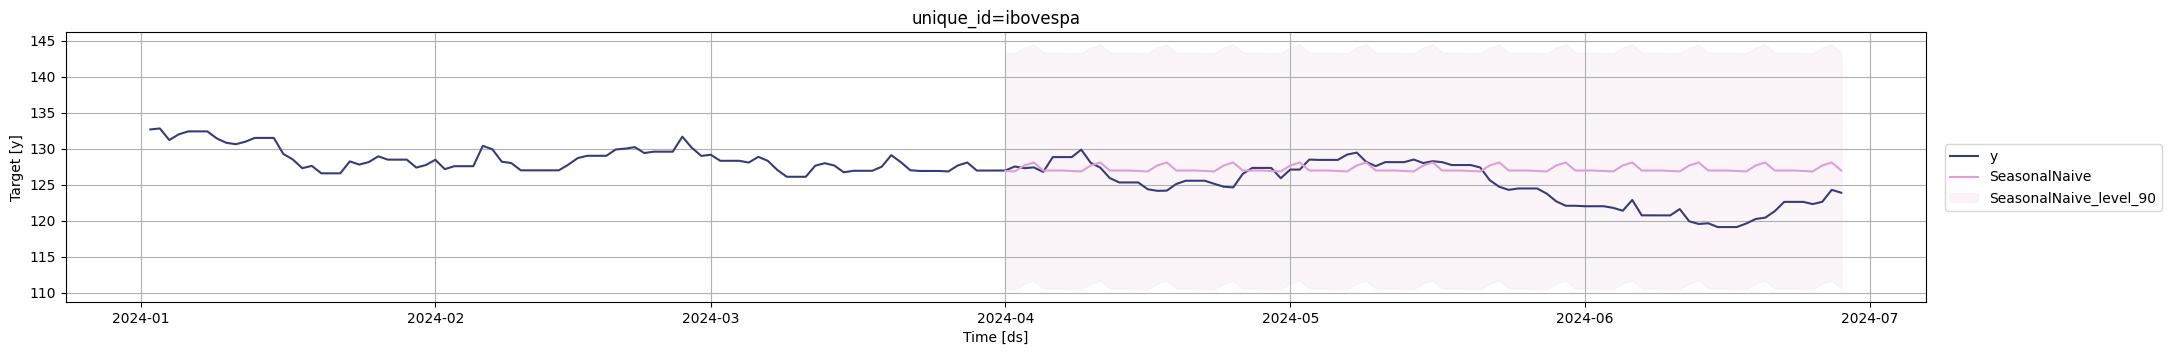

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

model_sn = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_sn.fit(treino)

forecast_df_sn = model_sn.predict(h=h, level=[90])
forecast_df_sn = forecast_df_sn.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# wMAPE
wmape_sn = wmape(forecast_df_sn['y'].values, forecast_df_sn['SeasonalNaive'].values)
print(f'WMAPE: {wmape_sn:.2%}')
# MSE
mse_sn = mean_squared_error(forecast_df_sn['y'], forecast_df_sn['SeasonalNaive'])
print('MSE:', mse_sn)
# RMSE
rmse_sn = np.sqrt(mse_sn)
print('RMSE:', rmse_sn)

model_sn.plot(treino, forecast_df_sn, level=[90], unique_ids=['ibovespa'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_df_sn.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,ibovespa,2024-04-01,126.931000,110.538803,143.323196,126.990
1,ibovespa,2024-04-02,126.862999,110.470802,143.255188,127.549
2,ibovespa,2024-04-03,127.691002,111.298805,144.083191,127.318
3,ibovespa,2024-04-04,128.106003,111.713806,144.498199,127.428
4,ibovespa,2024-04-05,126.989998,110.597801,143.382187,126.795


### SeasonalWindowAverage - Média Móvel com Sazonalidade

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.13%
MSE: 10.739613974816296
RMSE: 3.277135025417216


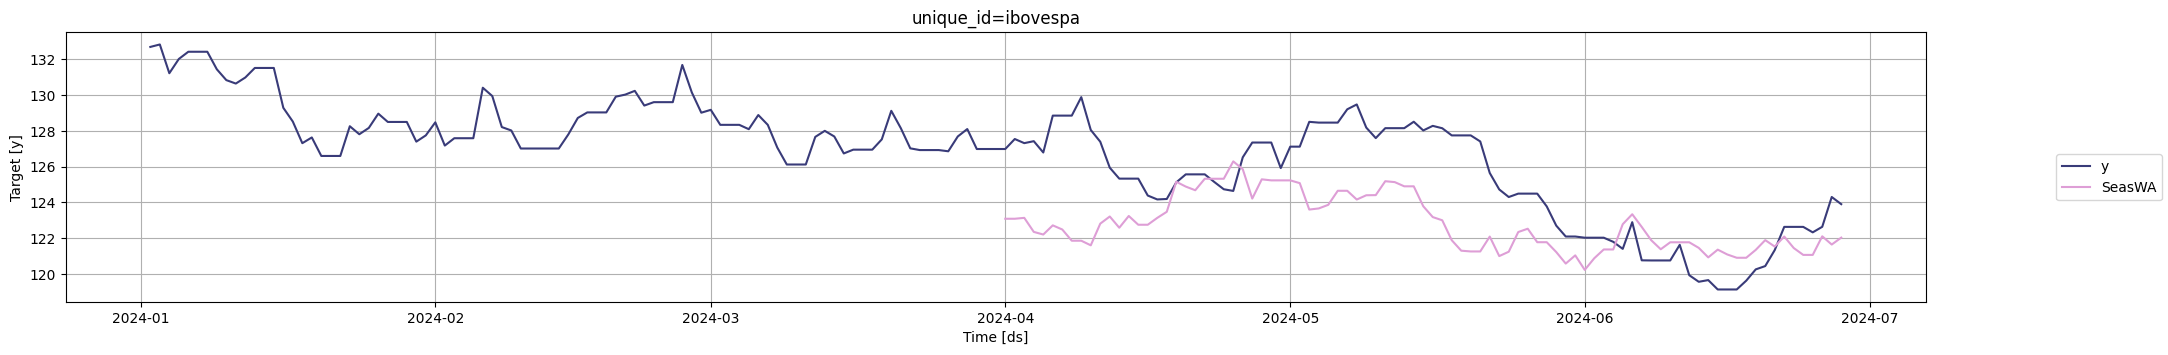

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalWindowAverage

model_swa = StatsForecast(models=[SeasonalWindowAverage(season_length=120, window_size=2)], freq='D', n_jobs=-1)
model_swa.fit(treino)

forecast_df_swa = model_swa.predict(h=h)
forecast_df_swa = forecast_df_swa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

#wMAPE
wmape_swa = wmape(forecast_df_swa['y'].values, forecast_df_swa['SeasWA'].values)
print(f'WMAPE: {wmape_swa:.2%}')
# MSE
mse_swa = mean_squared_error(forecast_df_swa['y'], forecast_df_swa['SeasWA'])
print('MSE:', mse_swa)
# RMSE
rmse_swa = np.sqrt(mse_swa)
print('RMSE:', rmse_swa)

model_swa.plot(treino, forecast_df_swa, unique_ids=['ibovespa'], engine='matplotlib', max_insample_length=90)

In [ ]:
df.head()

,ds,y,unique_id
0,2014-06-02,51.606,ibovespa
1,2014-06-03,52.032,ibovespa
2,2014-06-04,51.833,ibovespa
3,2014-06-05,51.559,ibovespa
4,2014-06-06,53.129,ibovespa


### ARIMA

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.30%
MSE: 13.321576746552303
RMSE: 3.6498735247337413


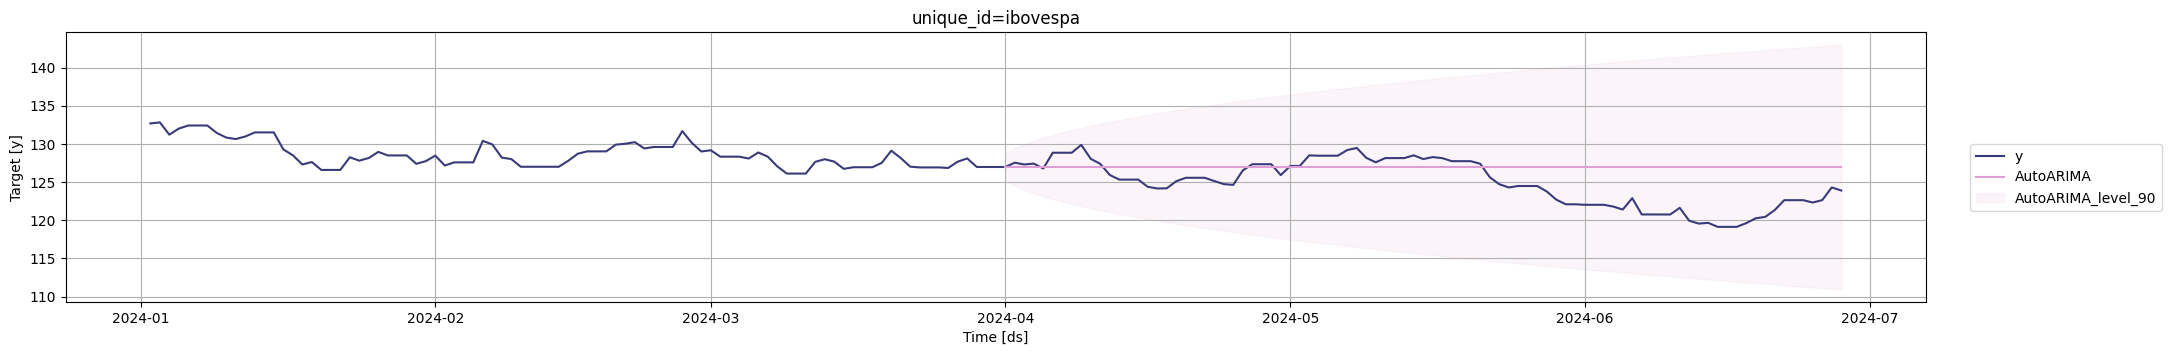

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

model_ar = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_ar.fit(treino)

forecast_df_ar = model_ar.predict(h=h, level=[90])
forecast_df_ar = forecast_df_ar.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# wMAPE
wmape_ar = wmape(forecast_df_ar['y'].values, forecast_df_ar['AutoARIMA'].values)
print(f'WMAPE: {wmape_ar:.2%}')
# MSE
mse_ar = mean_squared_error(forecast_df_ar['y'], forecast_df_ar['AutoARIMA'])
print('MSE:', mse_ar)
# RMSE
rmse_ar = np.sqrt(mse_ar)
print('RMSE:', rmse_ar)

model_ar.plot(treino, forecast_df_ar, level=[90], unique_ids=['ibovespa'], engine='matplotlib', max_insample_length=90)

### ETS

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 2.33%
MSE: 13.80920079233831
RMSE: 3.716073302874731


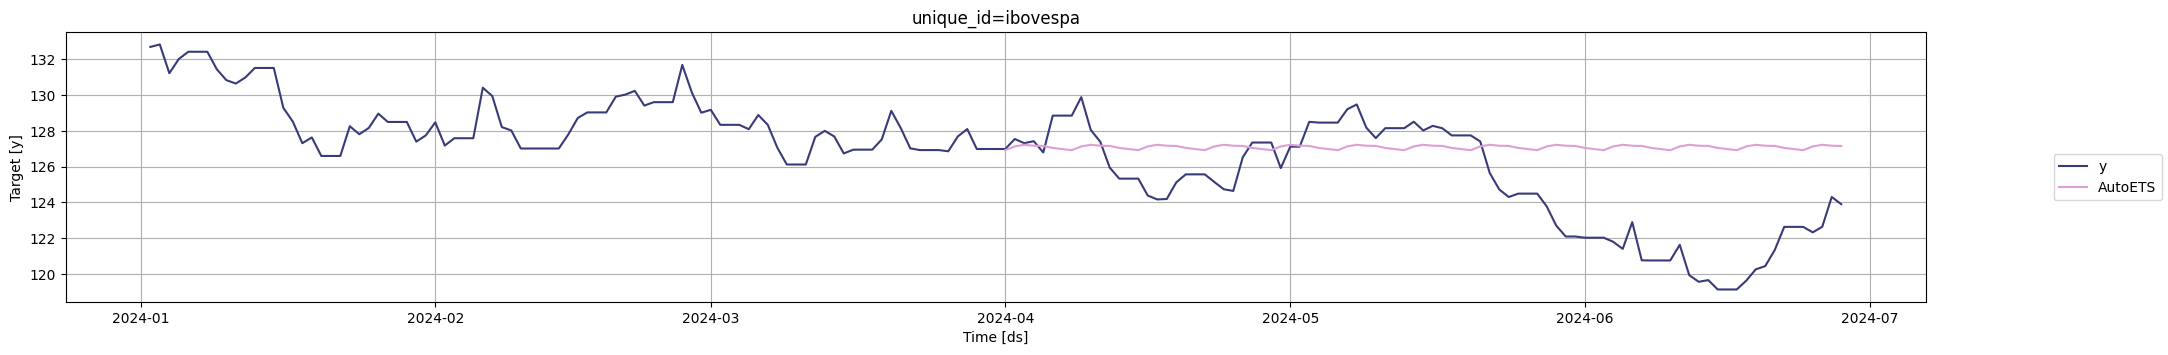

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

model_ets = StatsForecast(models=[AutoETS(season_length=7)], freq='D', n_jobs=-1)
model_ets.fit(treino)

forecast_df_ets = model_ets.predict(h=h)
forecast_df_ets = forecast_df_ets.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# wMAPE
wmape_ets = wmape(forecast_df_ets['y'].values, forecast_df_ets['AutoETS'].values)
print(f'WMAPE: {wmape_ets:.2%}')
# MSE
mse_ets = mean_squared_error(forecast_df_ets['y'], forecast_df_ets['AutoETS'])
print('MSE:', mse_ets)
# RMSE
rmse_ets = np.sqrt(mse_ets)
print('RMSE:', rmse_ets)

model_ets.plot(treino, forecast_df_ets, unique_ids=['ibovespa'], engine='matplotlib', max_insample_length=90)

In [ ]:
forecast_df_ets

,unique_id,ds,AutoETS,y
0,ibovespa,2024-04-01,126.924911,126.990
1,ibovespa,2024-04-02,127.133827,127.549
2,ibovespa,2024-04-03,127.225883,127.318
3,ibovespa,2024-04-04,127.173355,127.428
4,ibovespa,2024-04-05,127.162193,126.795
...,...,...,...,...
84,ibovespa,2024-06-24,126.924911,122.637
85,ibovespa,2024-06-25,127.133827,122.331
86,ibovespa,2024-06-26,127.225883,122.641
87,ibovespa,2024-06-27,127.173355,124.308


### Prophet

In [ ]:
pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps8zv25nm/97af8mjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps8zv25nm/_x1nfp9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37404', 'data', 'file=/tmp/tmps8zv25nm/97af8mjy.json', 'init=/tmp/tmps8zv25nm/_x1nfp9g.json', 'output', 'file=/tmp/tmps8zv25nm/prophet_modelyteifv31/prophet_model-20240713133545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


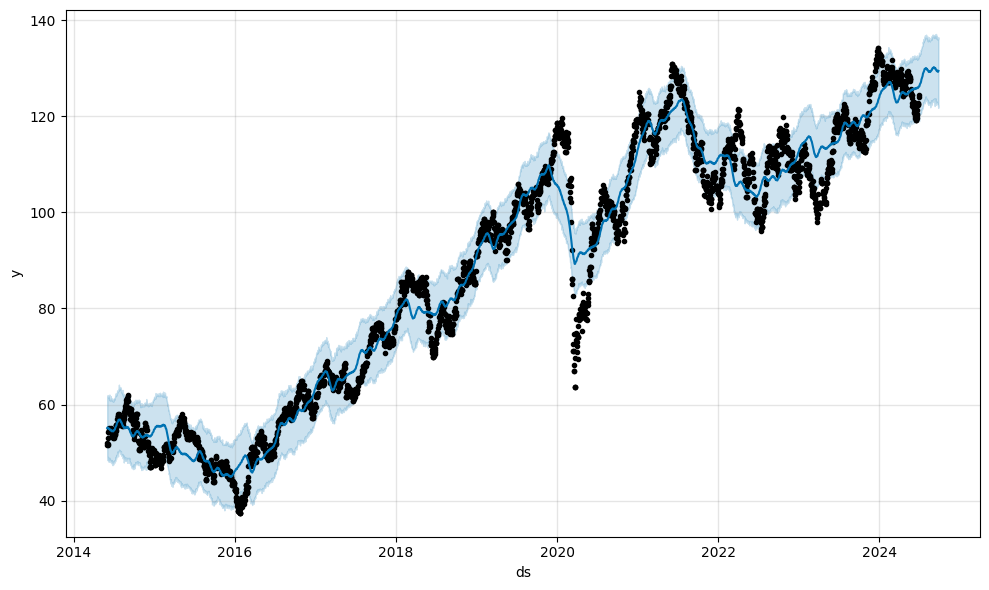

In [ ]:
from prophet import Prophet

df_prophet = df[['ds', 'y']]
df_prophet.head()

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=h)
forecast = model.predict(future)
forecast = forecast.reset_index().merge(valid, on=['ds'], how='left')


fig = model.plot(forecast)

In [ ]:
forecast = forecast.loc[(forecast['ds'] > '2024-04-01') & (forecast['ds'] <= '2024-06-28')]

In [ ]:
forecast

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
3592,3592,2024-04-02,125.148993,117.761281,130.404226,125.148993,125.148993,-1.153768,-1.153768,-1.153768,...,0.040605,-1.194373,-1.194373,-1.194373,0.0,0.0,0.0,123.995225,127.549,ibovespa
3593,3593,2024-04-03,125.179971,117.731527,130.999517,125.179971,125.179971,-1.008892,-1.008892,-1.008892,...,0.087560,-1.096452,-1.096452,-1.096452,0.0,0.0,0.0,124.171079,127.318,ibovespa
3594,3594,2024-04-04,125.210949,117.722577,130.896242,125.210949,125.210949,-0.954302,-0.954302,-0.954302,...,0.047942,-1.002244,-1.002244,-1.002244,0.0,0.0,0.0,124.256647,127.428,ibovespa
3595,3595,2024-04-05,125.241928,117.969341,130.697617,125.241928,125.241928,-0.886718,-0.886718,-0.886718,...,0.026833,-0.913551,-0.913551,-0.913551,0.0,0.0,0.0,124.355210,126.795,ibovespa
3596,3596,2024-04-06,125.272906,117.529355,130.638586,125.272906,125.272906,-0.877781,-0.877781,-0.877781,...,-0.045785,-0.831996,-0.831996,-0.831996,0.0,0.0,0.0,124.395125,128.857,ibovespa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,3675,2024-06-24,127.720196,119.196438,132.352599,127.720196,127.720196,-1.869818,-1.869818,-1.869818,...,-0.091636,-1.778182,-1.778182,-1.778182,0.0,0.0,0.0,125.850377,122.637,ibovespa
3676,3676,2024-06-25,127.751174,119.288421,131.941911,127.751174,127.751174,-1.731769,-1.731769,-1.731769,...,0.040605,-1.772374,-1.772374,-1.772374,0.0,0.0,0.0,126.019404,122.331,ibovespa
3677,3677,2024-06-26,127.782152,120.308046,132.241679,127.782152,127.782152,-1.672788,-1.672788,-1.672788,...,0.087560,-1.760348,-1.760348,-1.760348,0.0,0.0,0.0,126.109364,122.641,ibovespa
3678,3678,2024-06-27,127.813131,119.897558,132.655468,127.813131,127.813131,-1.693404,-1.693404,-1.693404,...,0.047942,-1.741346,-1.741346,-1.741346,0.0,0.0,0.0,126.119726,124.308,ibovespa


In [ ]:
# wMAPE
wmape_prophet = wmape(forecast['y'].values, forecast['yhat'].values)
print(f'WMAPE: {wmape_prophet:.2%}')
# MSE
mse_prophet = mean_squared_error(forecast['y'], forecast['yhat'])
print('MSE:', mse_prophet)
# RMSE
rmse_prophet = np.sqrt(mse_prophet)
print('RMSE:', rmse_prophet)


WMAPE: 2.42%
MSE: 12.117645254719429
RMSE: 3.4810408292232697


In [ ]:
valid

,ds,y,unique_id
3591,2024-04-01,126.990,ibovespa
3592,2024-04-02,127.549,ibovespa
3593,2024-04-03,127.318,ibovespa
3594,2024-04-04,127.428,ibovespa
3595,2024-04-05,126.795,ibovespa
...,...,...,...
3675,2024-06-24,122.637,ibovespa
3676,2024-06-25,122.331,ibovespa
3677,2024-06-26,122.641,ibovespa
3678,2024-06-27,124.308,ibovespa


In [ ]:
forecast.head()

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
3592,3592,2024-04-02,125.148993,117.761281,130.404226,125.148993,125.148993,-1.153768,-1.153768,-1.153768,...,0.040605,-1.194373,-1.194373,-1.194373,0.0,0.0,0.0,123.995225,127.549,ibovespa
3593,3593,2024-04-03,125.179971,117.731527,130.999517,125.179971,125.179971,-1.008892,-1.008892,-1.008892,...,0.087560,-1.096452,-1.096452,-1.096452,0.0,0.0,0.0,124.171079,127.318,ibovespa
3594,3594,2024-04-04,125.210949,117.722577,130.896242,125.210949,125.210949,-0.954302,-0.954302,-0.954302,...,0.047942,-1.002244,-1.002244,-1.002244,0.0,0.0,0.0,124.256647,127.428,ibovespa
3595,3595,2024-04-05,125.241928,117.969341,130.697617,125.241928,125.241928,-0.886718,-0.886718,-0.886718,...,0.026833,-0.913551,-0.913551,-0.913551,0.0,0.0,0.0,124.355210,126.795,ibovespa
3596,3596,2024-04-06,125.272906,117.529355,130.638586,125.272906,125.272906,-0.877781,-0.877781,-0.877781,...,-0.045785,-0.831996,-0.831996,-0.831996,0.0,0.0,0.0,124.395125,128.857,ibovespa


# Compilando resultados de wMAPE

In [ ]:
# prompt: printar todos os wmape

print(f'WMAPE Naive: {wmape_n:.2%}')
print(f'MSE Naive: {round(mse_n,2)}')
print(f'RMSE Naive: {round(rmse_n,2)}')
print('')
print(f'WMAPE SeasonalNaive: {wmape_sn:.2%}')
print(f'MSE SeasonalNaive: {round(mse_sn,2)}')
print(f'RMSE SeasonalNaive: {round(rmse_sn,2)}')
print('')
print(f'WMAPE SeasonalWindowAverage: {wmape_swa:.2%}')
print(f'MSE SeasonalWindowAverage: {round(mse_swa,2)}')
print(f'RMSE SeasonalWindowAverage: {round(rmse_swa,2)}')
print('')
print(f'WMAPE AutoARIMA: {wmape_ar:.2%}')
print(f'MSE AutoARIMA: {round(mse_ar,2)}')
print(f'RMSE AutoARIMA: {round(rmse_ar,2)}')
print('')
print(f'WMAPE AutoETS: {wmape_ets:.2%}')
print(f'MSE AutoETS: {round(mse_ets,2)}')
print(f'RMSE AutoETS: {round(rmse_ets,2)}')
print('')
print(f'WMAPE Prophet: {wmape_prophet:.2%}')
print(f'MSE Prophet: {round(mse_prophet,2)}')
print(f'RMSE Prophet: {round(rmse_prophet,2)}')



WMAPE Naive: 2.30%
MSE Naive: 13.32
RMSE Naive: 3.65

WMAPE SeasonalNaive: 2.40%
MSE SeasonalNaive: 14.68
RMSE SeasonalNaive: 3.83

WMAPE SeasonalWindowAverage: 2.13%
MSE SeasonalWindowAverage: 10.74
RMSE SeasonalWindowAverage: 3.28

WMAPE AutoARIMA: 2.30%
MSE AutoARIMA: 13.32
RMSE AutoARIMA: 3.65

WMAPE AutoETS: 2.33%
MSE AutoETS: 13.81
RMSE AutoETS: 3.72

WMAPE Prophet: 2.42%
MSE Prophet: 12.12
RMSE Prophet: 3.48
